## Standard Imports

In [2]:
import pandas as pd
import numpy as np
from IPython.display import clear_output
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from polire.placement import NottDuns, Stationary

## Data Loading

In [3]:
tdata = pd.read_pickle('../dataset/TempData.pickle')
tdata = tdata['2004-02-28':'2004-03-01']
loc_df = pd.read_csv('../dataset/mote_locs.txt', sep=' ',names=[0,'X','Y']).set_index(0)

M = 22
cross_df = pd.crosstab(tdata.index, tdata.ID, tdata.Temp, aggfunc=lambda x:list(x)[0])
cross_df = cross_df.resample(str(M)+'min').mean().dropna(how='any')
print(cross_df.shape, len(cross_df.dropna()), cross_df.cov().dropna().shape)

G_all = (((cross_df - cross_df.mean()).T).dot(cross_df - cross_df.mean())/len(cross_df)) # Estim. Cov. Mat.
G_all_npcov = cross_df.cov()
train_data = loc_df.loc[cross_df.columns][['X','Y']]
train_data['Temp'] = cross_df.mean()

ttdata = pd.read_pickle('/home/patel_zeel/Krause-NOSP-Replication/Data/TempData.pickle')
ttdata = ttdata['2004-03-02':'2004-03-02']
cross_df = pd.crosstab(ttdata.index, ttdata.ID, ttdata.Temp, aggfunc=lambda x:list(x)[0])
cross_df = cross_df.resample(str(M)+'min').mean().dropna(how='any')
print(cross_df.shape, len(cross_df.dropna()), cross_df.cov().dropna().shape)

G_all_test = (((cross_df - cross_df.mean(axis=0)).T).dot(cross_df - cross_df.mean(axis=0))/len(cross_df))
G_all_test_npcov = cross_df.cov()
test_data = loc_df.loc[cross_df.columns][['X','Y']]
test_data['Temp'] = cross_df.mean()

(181, 52) 181 (52, 52)
(62, 52) 62 (52, 52)


## Destroying ID to maintain consistency between pandas and numpy

In [4]:
train_data = train_data.reset_index(drop=True)
G_all = pd.DataFrame(G_all.values, index=range(len(train_data)), columns=range(len(train_data)))

#train_data = train_data.iloc[:16]
#G_all = G_all.iloc[:16, :16]

test_data = test_data.reset_index(drop=True)
G_all_test = pd.DataFrame(G_all_test.values, index=range(len(test_data)), columns=range(len(test_data)))

## Visualize train sensor locations in the 2D space

(10, 3) (10, 10)


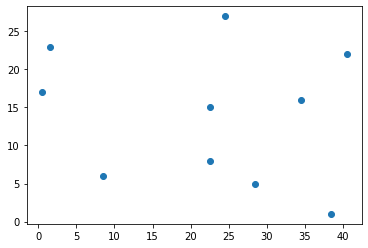

In [5]:
Seed = 42
train_sample = train_data.sample(10, random_state=Seed)
G = G_all.loc[train_sample.index, train_sample.index]
print(train_sample.shape, G.shape)
plt.scatter(train_sample['X'], train_sample['Y'])

X_train = train_sample[['X','Y']].values
y_train = train_sample[['Temp']].values.reshape(-1,1)

## Learning the NS kernel

In [8]:
nonStat = NottDuns(N=5, eta=1)
nonStat.fit(X_train, y_train, G.values)

## Greedy algorithm for Near Optimal Sensor Placement!

In [9]:
NN = 30
Pilot_ind = train_sample.index.tolist()
A_ind_MI, _ = nonStat.place(train_data[['X', 'Y']].values, Pilot_ind, N=NN, method='MI')
A_ind_Var, _ = nonStat.place(train_data[['X', 'Y']].values, Pilot_ind, N=NN, method='Entropy')
MI = nonStat.MI
Var = nonStat.Var

## RMSE plot for Non-stationary interpolator

In [10]:
Gran = 10
Eta = 100
NN = lambda x: max(5, len(x)//3)
MI_rms = np.zeros((len(MI), len(cross_df.index[::Gran])))
Var_rms = np.zeros((len(Var), len(cross_df.index[::Gran])))
for iter_i, epoch_id in enumerate(cross_df.index[::Gran]):
    for sens_i in range(len(MI)):
        clear_output(wait=True)
        print(iter_i, sens_i)
        test_tmp = cross_df.loc[epoch_id].reset_index(drop=True)
        #rint(test_tmp)
        # Predict and save RMSE
        
        # For Variance based locations ------------------

        GP_train_X = train_data.loc[A_ind_Var[:sens_i]+Pilot_ind][['X','Y']].values
        GP_train_Y = test_tmp.loc[A_ind_Var[:sens_i]+Pilot_ind].values
        GP_test_X = train_data.drop(A_ind_Var[:sens_i]+Pilot_ind, axis=0)[['X','Y']].values
        GP_test_Y = test_tmp.drop(A_ind_Var[:sens_i]+Pilot_ind, axis=0).values

        G_test = G_all_test.loc[A_ind_Var[:sens_i]+Pilot_ind, A_ind_Var[:sens_i]+Pilot_ind].values
            
        model = NottDuns(N=NN(GP_train_X), eta=Eta, kernel_name='m32')
        model.fit(GP_train_X, GP_train_Y, G_test)
        GP_predict_Y = model.predict(GP_test_X)
        #GP_predict_Y = 18 + cov_func(GP_test_X, GP_train_X).dot(np.linalg.pinv(cov_func(GP_train_X, GP_train_X))).dot(GP_train_Y - GP_train_Y.mean())
        error = GP_test_Y - GP_predict_Y
        rms = np.sqrt(np.mean(error**2))
        Var_rms[sens_i, iter_i] = rms
        
        # For MI based locations ------------------
        GP_train_X = train_data.loc[A_ind_MI[:sens_i]+Pilot_ind][['X','Y']].values 
        GP_train_Y = test_tmp.loc[A_ind_MI[:sens_i]+Pilot_ind].values
        GP_test_X = train_data.drop(A_ind_MI[:sens_i]+Pilot_ind, axis=0)[['X','Y']].values
        GP_test_Y = test_tmp.drop(A_ind_MI[:sens_i]+Pilot_ind, axis=0).values

        G_test = G_all_test.loc[A_ind_MI[:sens_i]+Pilot_ind, A_ind_MI[:sens_i]+Pilot_ind].values
        
        model = NottDuns(N=NN(GP_train_X), eta=Eta, kernel_name='m32')
        model.fit(GP_train_X, GP_train_Y, G_test)
        GP_predict_Y = model.predict(GP_test_X)
        #GP_predict_Y = 18 + cov_func(GP_test_X, GP_train_X).dot(np.linalg.pinv(cov_func(GP_train_X, GP_train_X))).dot(GP_train_Y - GP_train_Y.mean())
        error = GP_test_Y - GP_predict_Y
        rms = np.sqrt(np.mean(error**2))
        MI_rms[sens_i, iter_i] = rms

6 29


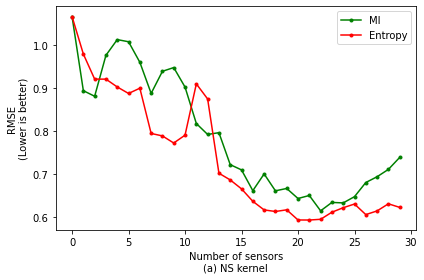

In [11]:
MM = 3
MI_rms_mean = MI_rms.mean(axis=1)
Var_rms_mean = Var_rms.mean(axis=1)

fig, ax = plt.subplots()
tmp = ax.plot(range(len(MI_rms_mean)), MI_rms_mean, 'go-', label='MI', markersize=MM)

tmp = ax.plot(range(len(Var_rms_mean)), Var_rms_mean, 'ro-', label='Entropy', markersize=MM)

ax.set_xlabel('Number of sensors\n(a) NS kernel')
ax.set_ylabel('RMSE\n(Lower is better)')
ax.legend()
plt.tight_layout()
plt.show()

## Learning the stationary model

In [12]:
Stat = Stationary(1,'m32',True)
Stat.fit(X_train, y_train)

Optimization restart 1/1, f = 18.31987830195559


## Greedy placement

In [13]:
NN = 30
Pilot_ind = train_sample.index.tolist()
A_ind_MI, _ = Stat.place(train_data[['X', 'Y']].values, Pilot_ind, N=NN, method='MI')
A_ind_Var, _ = Stat.place(train_data[['X', 'Y']].values, Pilot_ind, N=NN, method='Entropy')
MI = Stat.MI
Var = Stat.Var

## RMSE plot

In [14]:
Gran = 10
MI_rms = np.zeros((len(MI), len(cross_df.index[::Gran])))
Var_rms = np.zeros((len(Var), len(cross_df.index[::Gran])))
for iter_i, epoch_id in enumerate(cross_df.index[::Gran]):
    for sens_i in range(len(MI)):
        clear_output(wait=True)
        print(iter_i, sens_i)
        test_tmp = cross_df.loc[epoch_id].reset_index(drop=True)
        # Predict and save RMSE
        
        # For Variance based locations ------------------

        GP_train_X = train_data.loc[A_ind_Var[:sens_i]+Pilot_ind][['X','Y']].values
        GP_train_Y = test_tmp.loc[A_ind_Var[:sens_i]+Pilot_ind].values.reshape(-1,1)
        GP_test_X = train_data.drop(A_ind_Var[:sens_i]+Pilot_ind, axis=0)[['X','Y']].values
        GP_test_Y = test_tmp.drop(A_ind_Var[:sens_i]+Pilot_ind, axis=0).values.reshape(-1,1)

        Stat = Stationary(1, 'm32', True)
        Stat.fit(GP_train_X, GP_train_Y)
        GP_predict_Y = Stat.predict(GP_test_X)
        error = GP_test_Y - GP_predict_Y
        rms = np.sqrt(np.mean(error**2))
        Var_rms[sens_i, iter_i] = rms
        
        # For MI based locations ------------------
        GP_train_X = train_data.loc[A_ind_MI[:sens_i]+Pilot_ind][['X','Y']].values 
        GP_train_Y = test_tmp.loc[A_ind_MI[:sens_i]+Pilot_ind].values.reshape(-1,1)
        GP_test_X = train_data.drop(A_ind_MI[:sens_i]+Pilot_ind, axis=0)[['X','Y']].values
        GP_test_Y = test_tmp.drop(A_ind_MI[:sens_i]+Pilot_ind, axis=0).values.reshape(-1,1)

        Stat = Stationary(1, 'm32', True)
        Stat.fit(GP_train_X, GP_train_Y)
        GP_predict_Y = Stat.predict(GP_test_X)

        error = GP_test_Y - GP_predict_Y
        rms = np.sqrt(np.mean(error**2))
        MI_rms[sens_i, iter_i] = rms

6 29
Optimization restart 1/1, f = 38.307975396807876
Optimization restart 1/1, f = 31.834445962590188


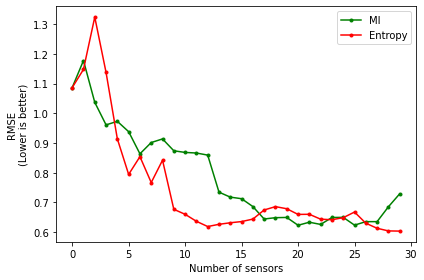

In [15]:
MM = 3
MI_rms_mean = MI_rms.mean(axis=1)
Var_rms_mean = Var_rms.mean(axis=1)

fig, ax = plt.subplots()
tmp = ax.plot(range(len(MI_rms_mean)), MI_rms_mean, 'go-', label='MI', markersize=MM)
tmp = ax.plot(range(len(Var_rms_mean)), Var_rms_mean, 'ro-', label='Entropy', markersize=MM)
ax.set_xlabel('Number of sensors')
ax.set_ylabel('RMSE\n(Lower is better)')
ax.legend()
plt.tight_layout()
plt.show()